# An Analysis of Wind Speeds in the North Sea

---

### Data

We will be working with [data](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/) collected by [DWD](https://dwd.de) on Helgoland in a 10-minute intervall from 1996 to 2022. For loading the data, we have to manually collect the from a http server.


### Imports and Usage

You can simply use the `environment.yml` file to create a new conda environment with all the needed packages by running `conda env create -f environment.yml`. The only relevant parameter you may want to change is `RELOAD`. If set to `True`, all the needed data will be downloaded and saved in the `data/` folder.

## Data Loading

In [47]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import requests as rq
import zipfile
from bs4 import BeautifulSoup
import os
import seaborn as sns
import pickle
import datetime as dt
import matplotlib.dates as mdt
from tueplots import bundles
import tueplots as tp
import math
import scipy.optimize as opt

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams['figure.dpi'] = 400
plt.rcParams["font.family"] = "DejaVu Sans"

# set true to download the data and unzip into the current directory
RELOAD = False
ZIP_NAME = "data.zip"
DATA_FOLDER = "data"

DATA_BASE_URL = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/"
KINDS = ["wind", "air_temperature", "precipitation", "solar"]
METRIC_URLS = [DATA_BASE_URL + postfix + "/historical/" for postfix in KINDS]
print(METRIC_URLS)

['https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/wind/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/precipitation/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/solar/historical/']


In [3]:
def download_and_extract(url: str, kind: str, station_id: str = "02115") -> dict:
    response = rq.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    # find dataset desciption (pdf)
    descr_resp = rq.get(f"{DATA_BASE_URL}/{kind}")
    descr_soup = BeautifulSoup(descr_resp.text, "html.parser")
    descriptions = [a.get("href") for a in descr_soup.find_all("a", href=True) if a.get("href").__contains__("pdf")]
    descrs_resps = list(map(lambda desc: rq.get(f"{DATA_BASE_URL}/{kind}/{desc}"), descriptions))

    # Extract all links with data of the appropiate station
    links = [a.get("href") for a in soup.find_all('a', href=True) if a.get("href").__contains__(station_id)]
    print(f"Found links: {links}")

    responses = [rq.get(url + file) for file in links]

    # check if we need to create folders
    save_path = os.path.join("data", kind)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # save dataset description pdfs
    for descr, resp in zip(descriptions, descrs_resps):
        with open(os.path.join(save_path, descr), "wb") as file:
            file.write(resp.content)

    # for each matching response download the zip and extract it
    files = [] # remember file names of the extracted zip files
    for i, r in enumerate(responses):
        zip_name = os.path.join("data", kind, f"file{i}.zip")
        with open(zip_name, "wb") as z:
            z.write(r.content)

        with zipfile.ZipFile(zip_name, "r") as zip_file:
            for filename in zip_file.namelist():
                files.append(os.path.join(save_path, filename))
            zip_file.extractall(os.path.join("data", kind))

        # we don't need the zip anymore
        os.remove(zip_name)
    
    return files

# have mapping of metric to relevant files for loading into dataframes later on
kind_files = { kind : [] for kind in KINDS }
kind_file_paths = os.path.join("data", "contents.pickle")
if RELOAD:
    for kind, folder in zip(KINDS, METRIC_URLS):
        print(f"{kind}: {folder}")
        files = download_and_extract(folder, kind)
        kind_files[kind] = files

    with open(os.path.join(kind_file_paths), 'wb') as handle:
        pickle.dump(kind_files, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else:
    with open(kind_file_paths, 'rb') as handle:
        kind_files = pickle.load(handle)

for kind in KINDS:
    print(f"Files containing {kind} data:\n\t{kind_files[kind]}")

Files containing wind data:
	['data/wind/produkt_zehn_min_ff_19961220_19991231_02115.txt', 'data/wind/produkt_zehn_min_ff_20000101_20091231_02115.txt', 'data/wind/produkt_zehn_min_ff_20100101_20191231_02115.txt', 'data/wind/produkt_zehn_min_ff_20200101_20221231_02115.txt']
Files containing air_temperature data:
	['data/air_temperature/produkt_zehn_min_tu_19961219_19991231_02115.txt', 'data/air_temperature/produkt_zehn_min_tu_20000101_20091231_02115.txt', 'data/air_temperature/produkt_zehn_min_tu_20100101_20191231_02115.txt', 'data/air_temperature/produkt_zehn_min_tu_20200101_20221231_02115.txt']
Files containing precipitation data:
	['data/precipitation/produkt_zehn_min_rr_19961219_19991231_02115.txt', 'data/precipitation/produkt_zehn_min_rr_20000101_20091231_02115.txt', 'data/precipitation/produkt_zehn_min_rr_20100101_20191231_02115.txt', 'data/precipitation/produkt_zehn_min_rr_20200101_20221231_02115.txt']
Files containing solar data:
	['data/solar/produkt_zehn_min_sd_19961219_199912

In [4]:
kind_df = { kind: None for kind in KINDS }
for kind, files in kind_files.items():
    dfs = []
    for file in files:
        df = pd.read_csv(file, sep=";")
        df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d%H%M")
        dfs.append(df)
    df = pd.concat(dfs)
    df.sort_values(by="MESS_DATUM", inplace=True)
    df.columns = map(lambda c: c if c == "STATIONS_ID" or c == "MESS_DATUM" else f"{c}_{kind}", df.columns)
    # print(f"{kind}:\n{df.describe()}")
    kind_df[kind] = df

In [5]:
dfs = list(kind_df.values())
df = pd.merge(dfs[0], dfs[1], on=["MESS_DATUM", "STATIONS_ID"], how="inner", suffixes=tuple(list(map(lambda x: "_" + x, kind_df.keys()))[:2]))

# Loop through the remaining DataFrames and merge with the result
for i, df1 in enumerate(dfs[2:]):
    df = pd.merge(df, df1, on=["MESS_DATUM", "STATIONS_ID"], how="inner", suffixes=(None, "_" + list(kind_df.keys())[i+2]))

# Display the result
df

STATIONS_ID          MESS_DATUM    QN_wind  FF_10_wind  DD_10_wind  \
0               2115 1996-12-19 10:40:00          1        15.8          70   
1               2115 1996-12-19 10:50:00          1        16.2          70   
2               2115 1996-12-19 11:00:00          1        16.6          70   
3               2115 1996-12-19 11:10:00          1        16.0          80   
4               2115 1996-12-19 11:20:00          1        16.3          70   
...              ...                 ...        ...         ...         ...   
1348936         2115 2022-12-31 23:10:00          3        13.6         230   
1348937         2115 2022-12-31 23:20:00          3        12.4         230   
1348938         2115 2022-12-31 23:30:00          3        12.6         230   
1348939         2115 2022-12-31 23:40:00          3        12.6         230   
1348940         2115 2022-12-31 23:50:00          3        12.9         230   

        eor_wind  QN_air_temperature  PP_10_air_temperature  \
0            eor                 1.0                 1008.2   
1            eor                 1.0                 1008.1   
2            eor                 1.0                 1008.1   
3            eor                 1.0                 1008.1   
4            eor                 1.0                 1008.0   
...          ...                 ...                    ...   
1348936      eor                 NaN                 1000.6   
1348937      eor                 NaN                 1000.6   
1348938      eor                 NaN                 1000.5   
1348939      eor                 NaN                 1000.6   
1348940      eor                 NaN                 1000.7   

         TT_10_air_temperature  TM5_10_air_temperature  ...  \
0                          2.0                     1.9  ...   
1                          2.0                     1.9  ...   
2                          2.1                     2.1  ...   
3                          2.3                     2.2  ...   
4                          2.1                     2.0  ...   
...                        ...                     ...  ...   
1348936                   11.1                    10.3  ...   
1348937                   10.9                    10.2  ...   
1348938                   11.1                    10.3  ...   
1348939                   11.2                    10.4  ...   
1348940                   11.2                    10.4  ...   

         RWS_IND_10_precipitation    QN_precipitation  eor_precipitation  \
0                               0                 NaN                NaN   
1                               0                 NaN                NaN   
2                               0                 NaN                NaN   
3                               0                 NaN                NaN   
4                               0                 NaN                NaN   
...                           ...                 ...                ...   
1348936                         0                 3.0                eor   
1348937                         0                 3.0                eor   
1348938                         0                 3.0                eor   
1348939                         0                 3.0                eor   
1348940                         0                 3.0                eor   

        QN_solar  DS_10_solar  GS_10_solar  SD_10_solar  LS_10_solar  \
0            1.0       -999.0       -999.0          0.0         -999   
1            1.0       -999.0       -999.0          0.0         -999   
2            1.0       -999.0       -999.0          0.0         -999   
3            1.0       -999.0       -999.0          0.0         -999   
4            1.0       -999.0       -999.0          0.0         -999   
...          ...          ...          ...          ...          ...   
1348936      NaN          0.0          0.0          0.0         -999   
1348937      NaN          0.0          0.0          0.0  

## Explorative Data Analysis

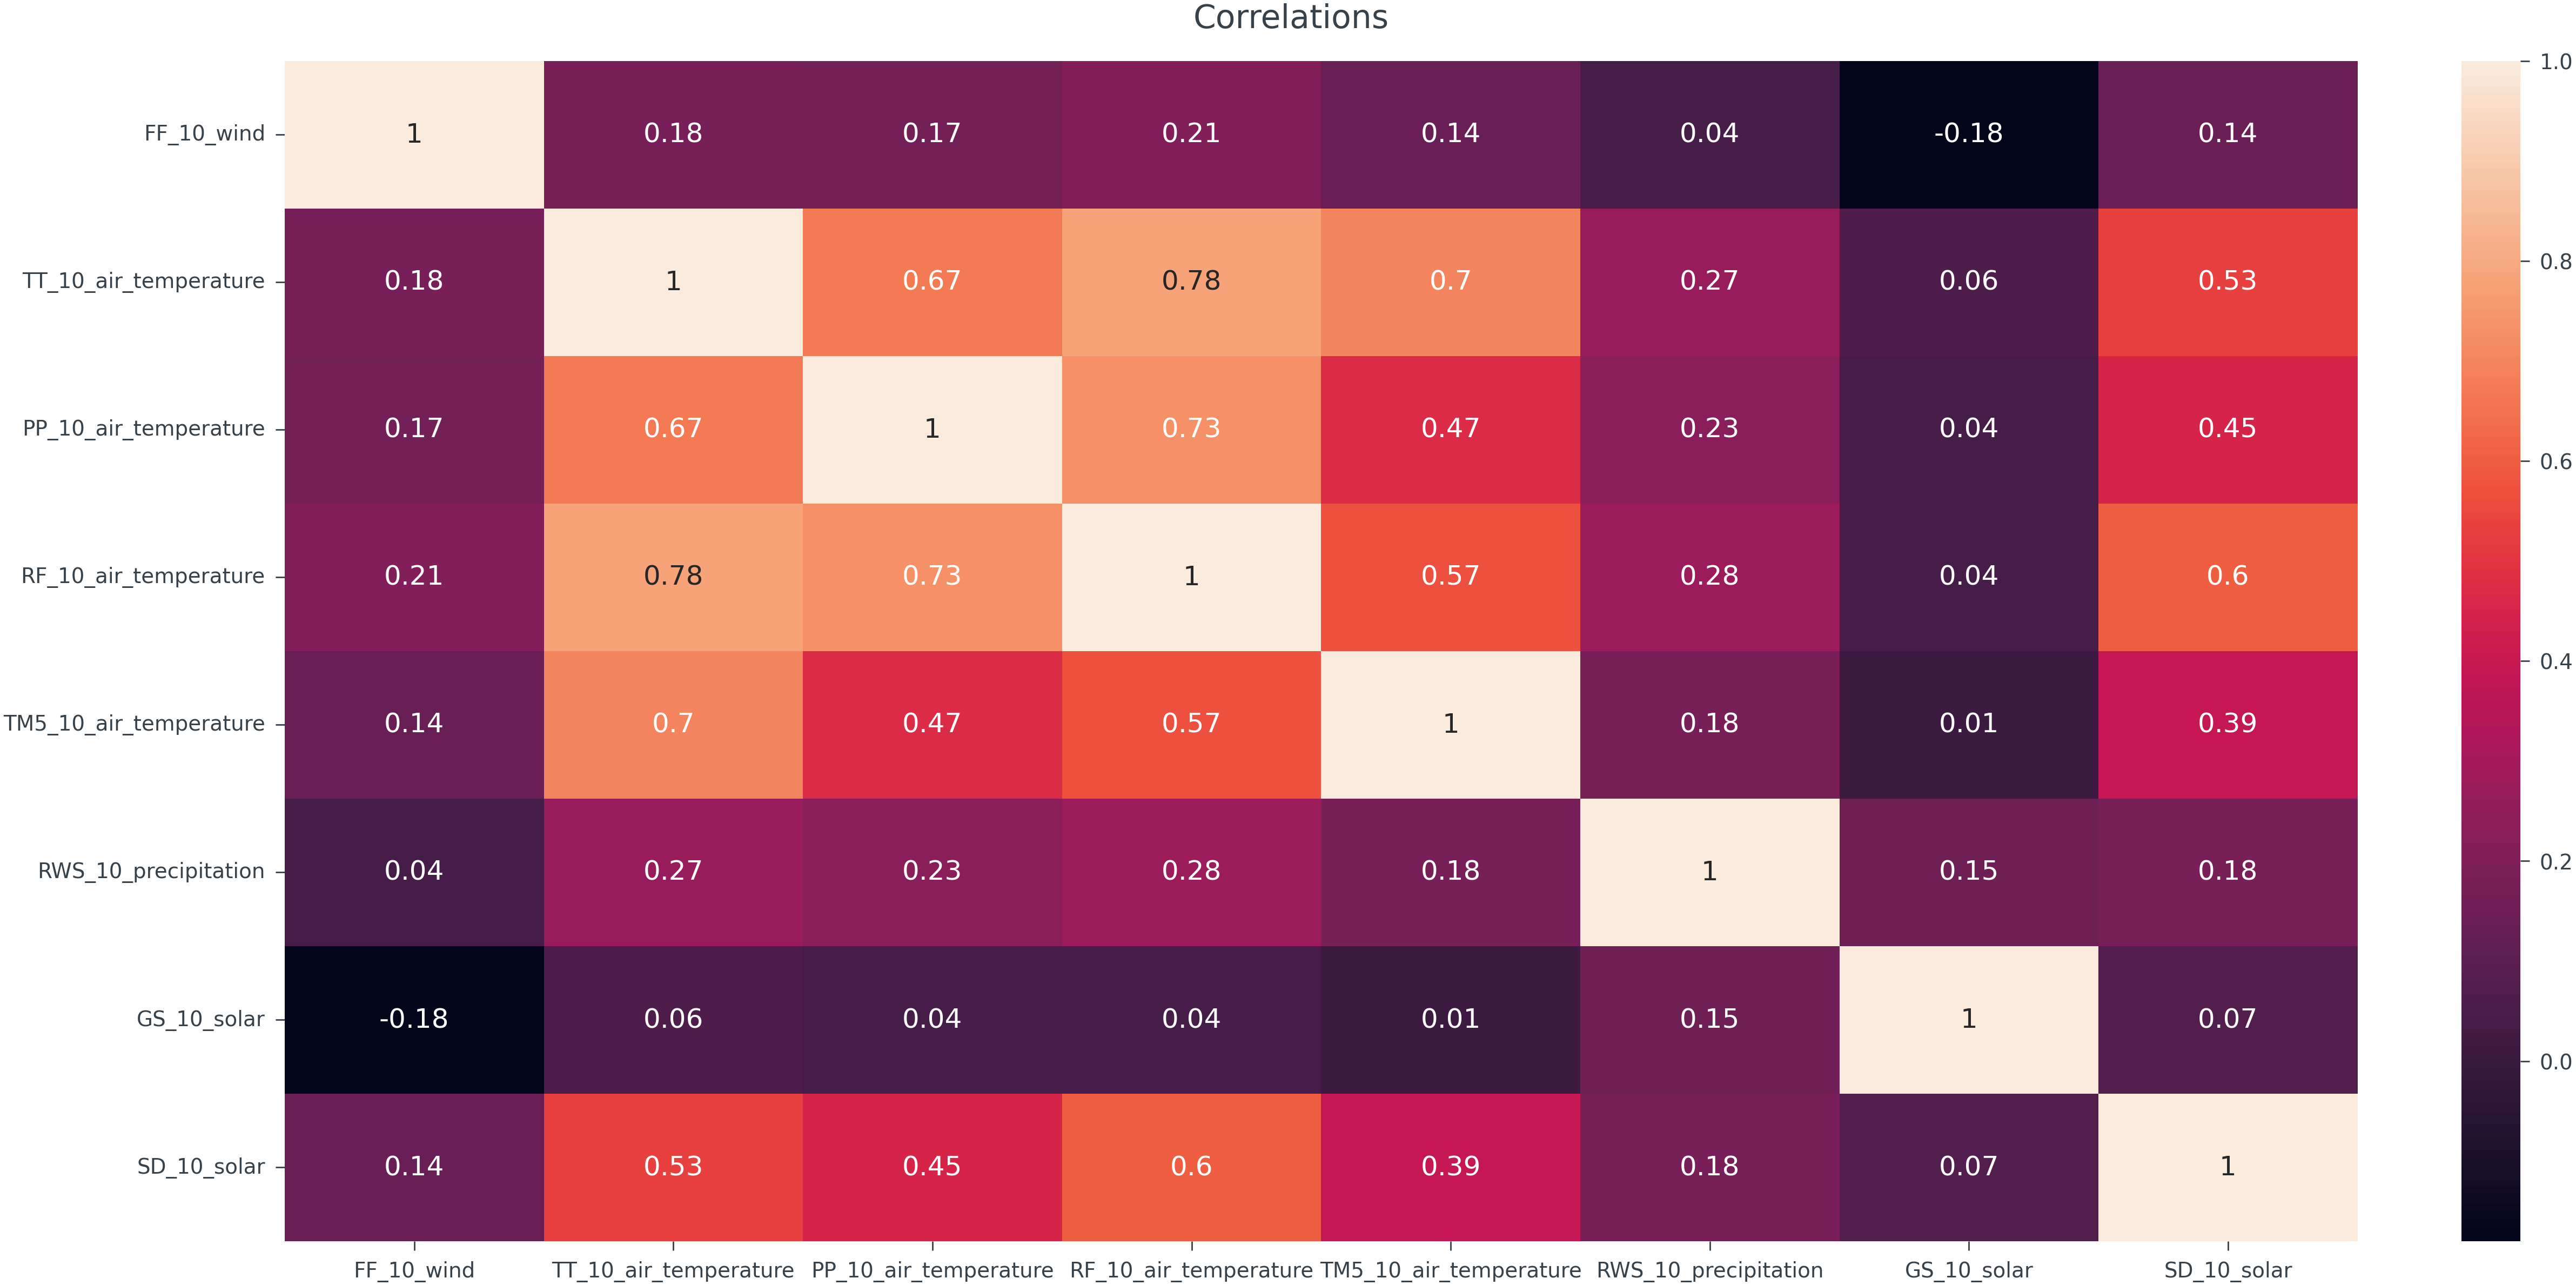

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
corr = df[["FF_10_wind", "TT_10_air_temperature", "PP_10_air_temperature", "RF_10_air_temperature", "TM5_10_air_temperature", "RWS_10_precipitation", "GS_10_solar", "SD_10_solar"]].corr().round(2)
ax = sns.heatmap(corr, annot=True)
fig.suptitle("Correlations")
plt.show()

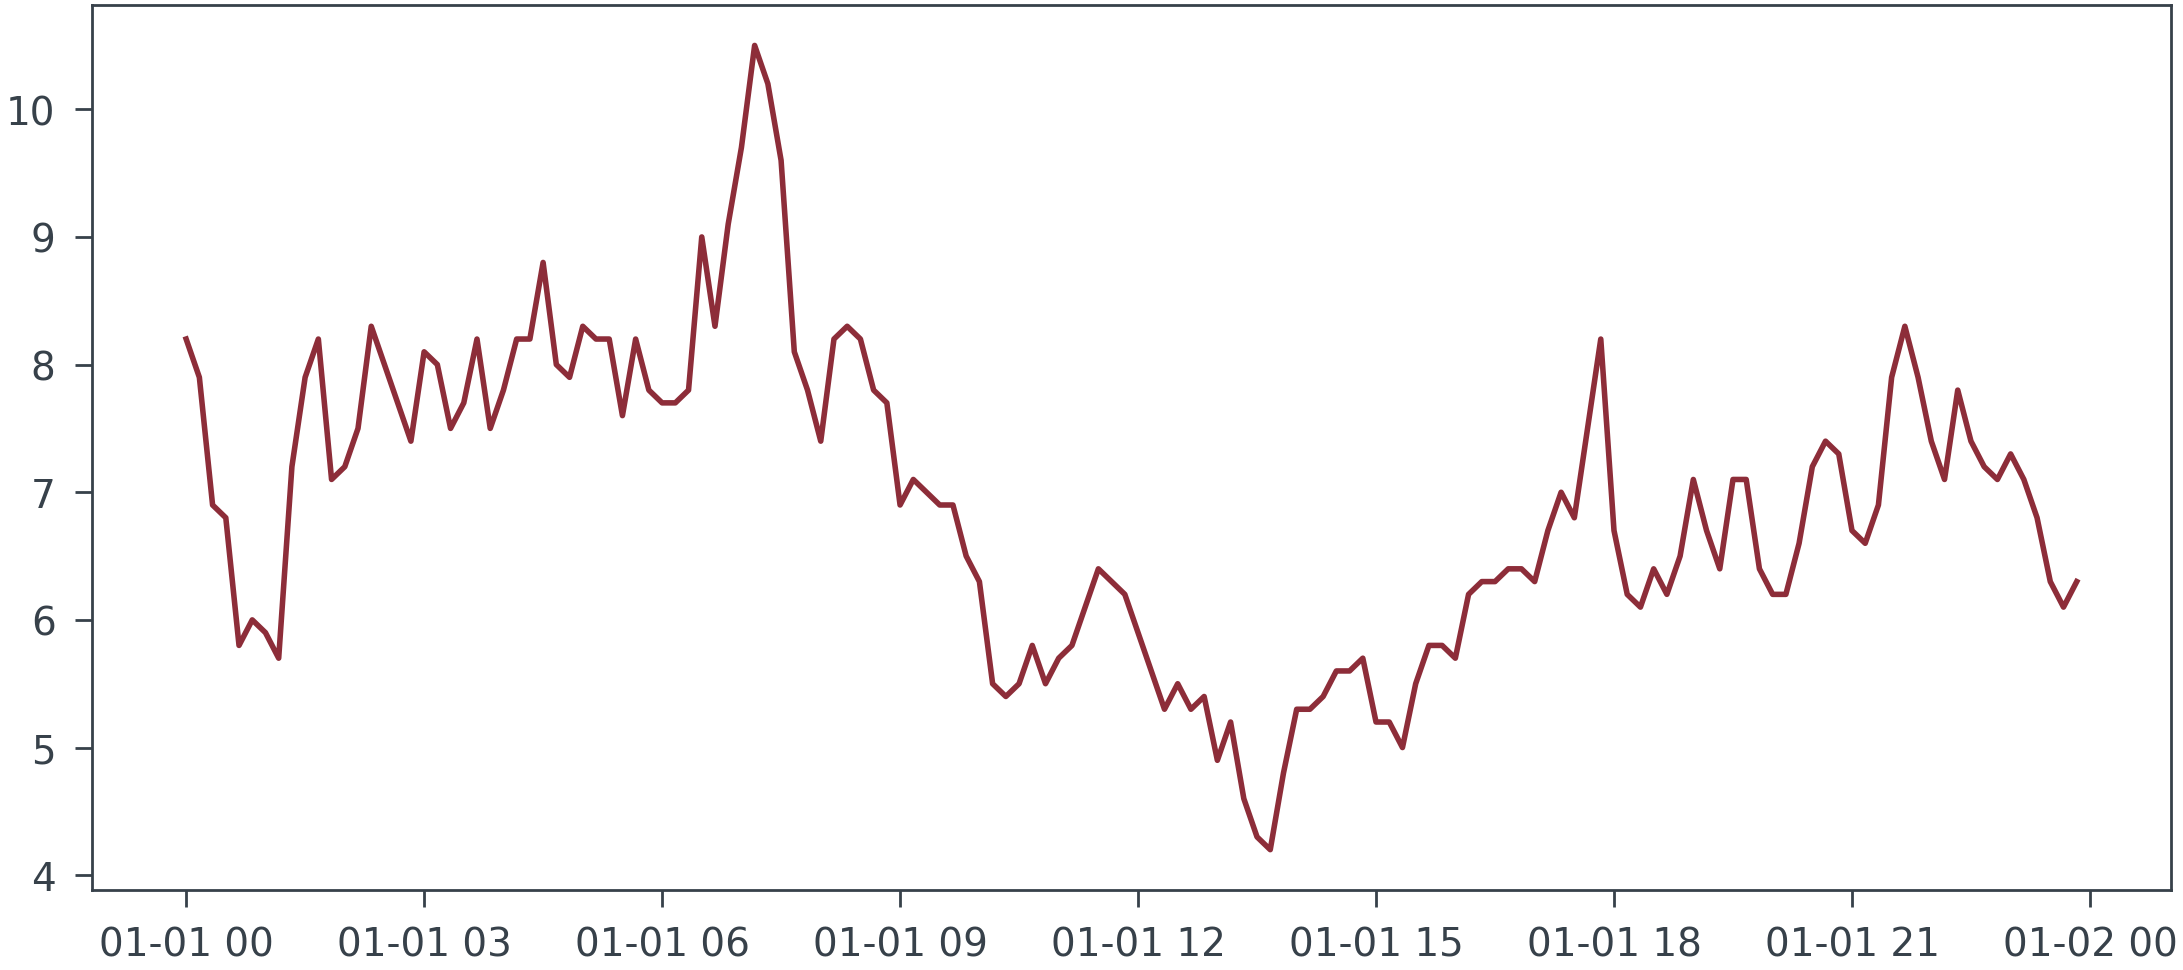

In [7]:
wind_df = kind_df["wind"]
wind_df['FF_10_wind'] = wind_df['FF_10_wind'].replace(-999, float('nan'))
mask = (wind_df['MESS_DATUM'].dt.day == 1) & (wind_df['MESS_DATUM'].dt.month == 1) & (wind_df['MESS_DATUM'].dt.year == 2022)
plt.plot(wind_df[mask]["MESS_DATUM"], wind_df[mask]["FF_10_wind"])


/var/folders/zk/8tsl64_x29qcn5z6qjdgwh5h0000gn/T/ipykernel_75774/1007860517.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


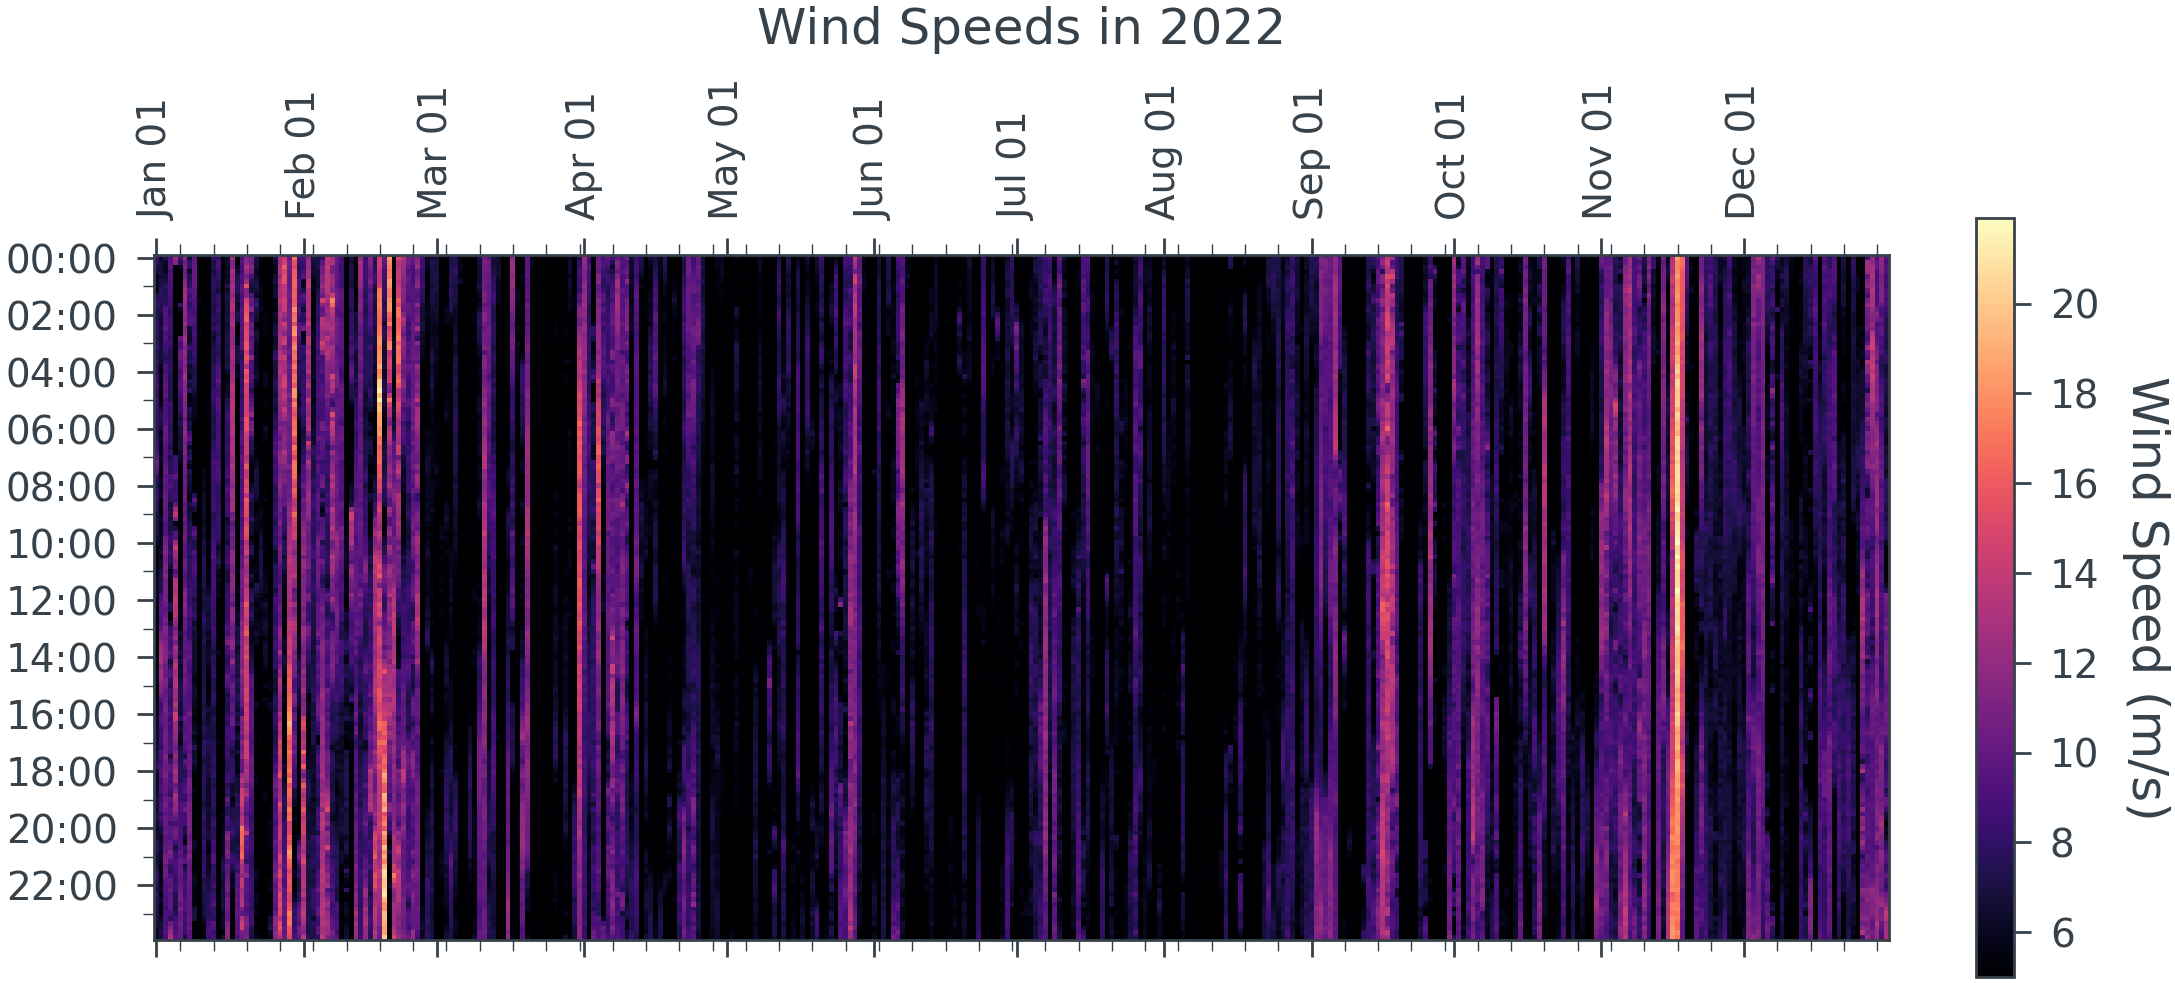

In [8]:
wind_df_2022 = wind_df[wind_df["MESS_DATUM"].dt.year == 2022].copy()
wind_df_2022["Day"] = wind_df_2022["MESS_DATUM"].dt.date
wind_df_2022["Time"] = wind_df_2022["MESS_DATUM"].dt.time

pivot_table_2022 = pd.pivot_table(
    wind_df_2022, values=("FF_10_wind"), index=["Time"], columns=["Day"], aggfunc="mean"
).fillna(0)

fig, ax = plt.subplots()
im = ax.matshow(pivot_table_2022, cmap="magma", vmin=5)

ax.set_yticks(np.arange(len(pivot_table_2022.index))[::12])
ax.set_yticks(np.arange(len(pivot_table_2022))[::6], minor=True)
ax.set_yticklabels([time.strftime("%H:%M") for time in pivot_table_2022.index[::12]])

ax.xaxis.set_major_locator(mdt.MonthLocator(interval=1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_minor_locator(
    mdt.WeekdayLocator(interval=1)
)
date_form = mdt.DateFormatter("%b %d")
ax.xaxis.set_major_formatter(date_form)
# ax.grid(which="major", axis="x", linestyle="--", linewidth="0.5", color="gray")
# ax.grid(which="major", axis="y", linestyle="--", linewidth="0.5", color="gray")

cbar = ax.figure.colorbar(im, ax=ax, shrink=1.0)
cbar.ax.set_ylabel("Wind Speed (m/s)", rotation=-90, va="bottom")

ax.set_title("Wind Speeds in 2022")
plt.show()

Text(0.5, 0.98, 'Wind Speeds 2015-2022')

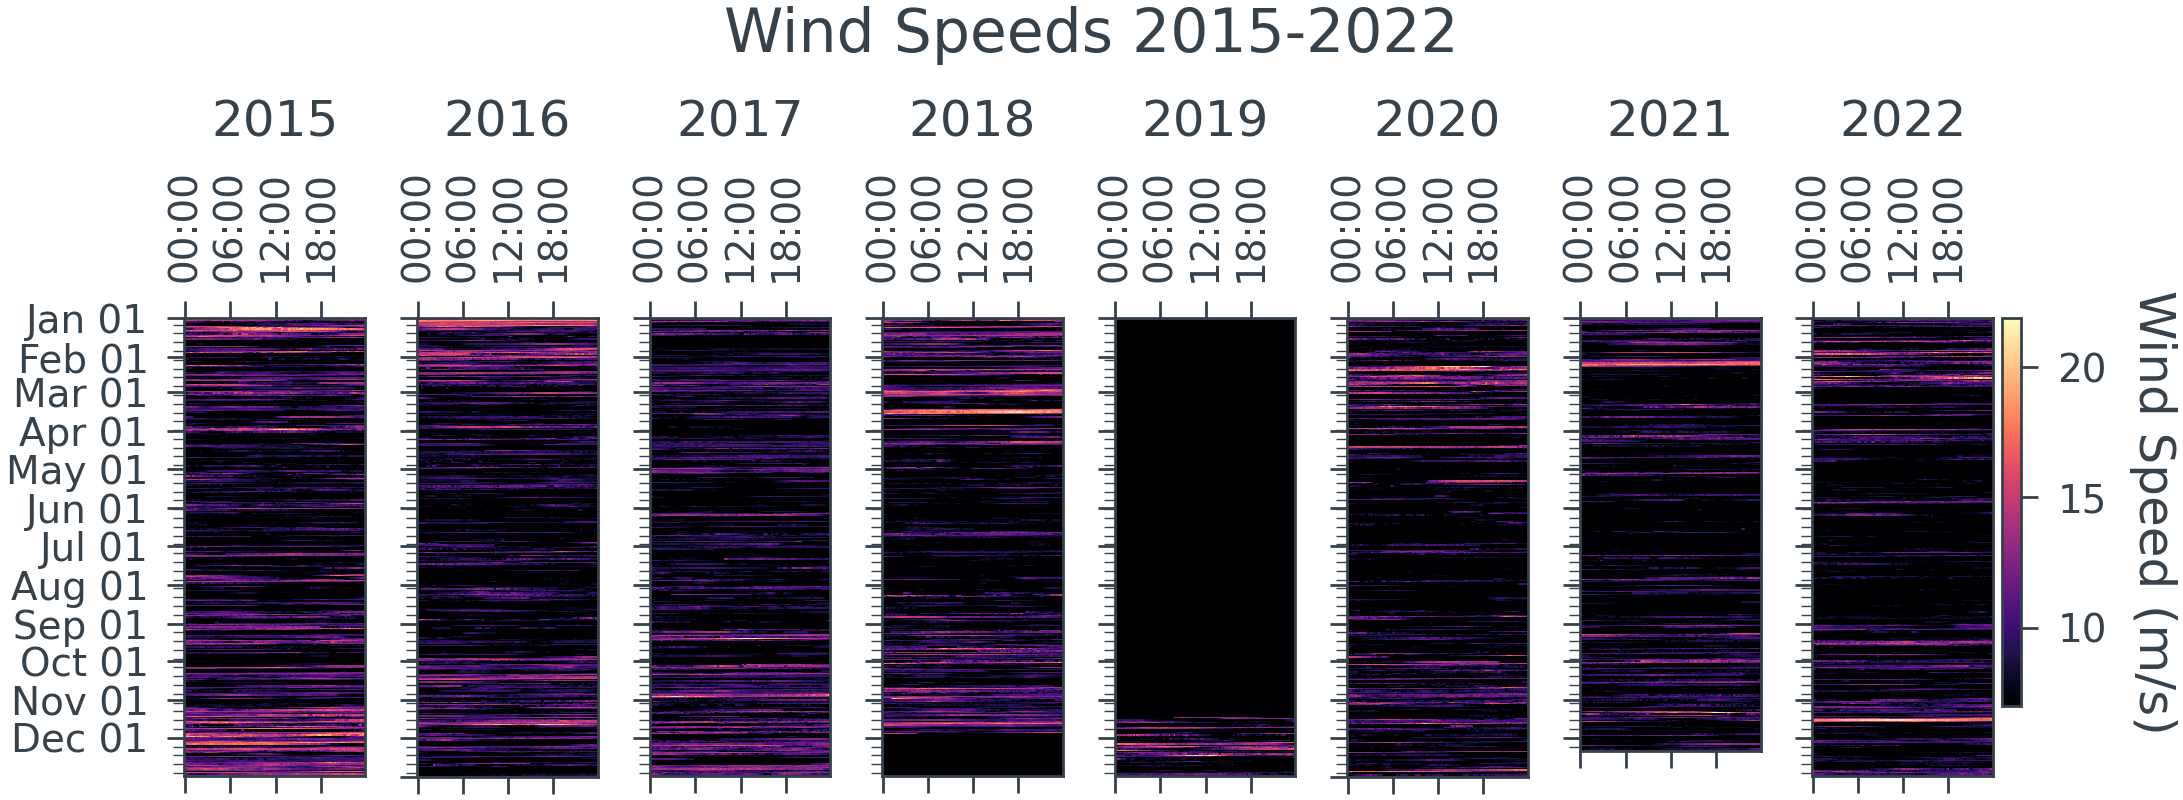

In [9]:
fig, axs = plt.subplots(1, 8, sharex=True, sharey=False)
# fig.suptitle("Wind Speeds in the years 2015-2022")

for i, year in enumerate(range(2015, 2023)):
    ax = axs[i]
    # ax.set_anchor("N")
    mask = wind_df["MESS_DATUM"].dt.year == year
    wind_df_year = wind_df[mask].copy()
    wind_df_year.fillna(0, inplace=True)

    wind_df_year["Day"] = wind_df_year["MESS_DATUM"].dt.date
    wind_df_year["Time"] = wind_df_year["MESS_DATUM"].dt.time

    pivot_table = pd.pivot_table(
        wind_df_year, values=("FF_10_wind"), index=["Day"], columns=["Time"], aggfunc="mean", fill_value=0
    )

    Daystrings = [date.strftime("%d %b") for date in pivot_table.index.values]
    TimeStrings = [time.strftime("%H:%M") for time in pivot_table.columns]

    im = ax.matshow(pivot_table, cmap="magma", vmin=7)

    ax.set_xticks(np.arange(len(pivot_table.columns))[:: (6 * 6)])
    ax.set_xticklabels(TimeStrings[:: (6 * 6)], rotation=90)
    ax.yaxis.set_major_locator(
        mdt.MonthLocator(interval=1)
    )
    ax.yaxis.set_minor_locator(
        mdt.WeekdayLocator(interval=1)
    )
    if i == 0:
        ax.yaxis.set_major_formatter(date_form)
    else:
        ax.set_yticklabels([])

    if i == 7:
        cbar = fig.colorbar(im, ax=ax, shrink=0.6, location="right", anchor=(0.0, 1.0))
        cbar.ax.set_ylabel("Wind Speed (m/s)", rotation=-90, va="bottom")

    ax.set_title(year)

for ax in axs:
    ax.set_anchor("N")
fig.suptitle("Wind Speeds 2015-2022")

(720, 1)


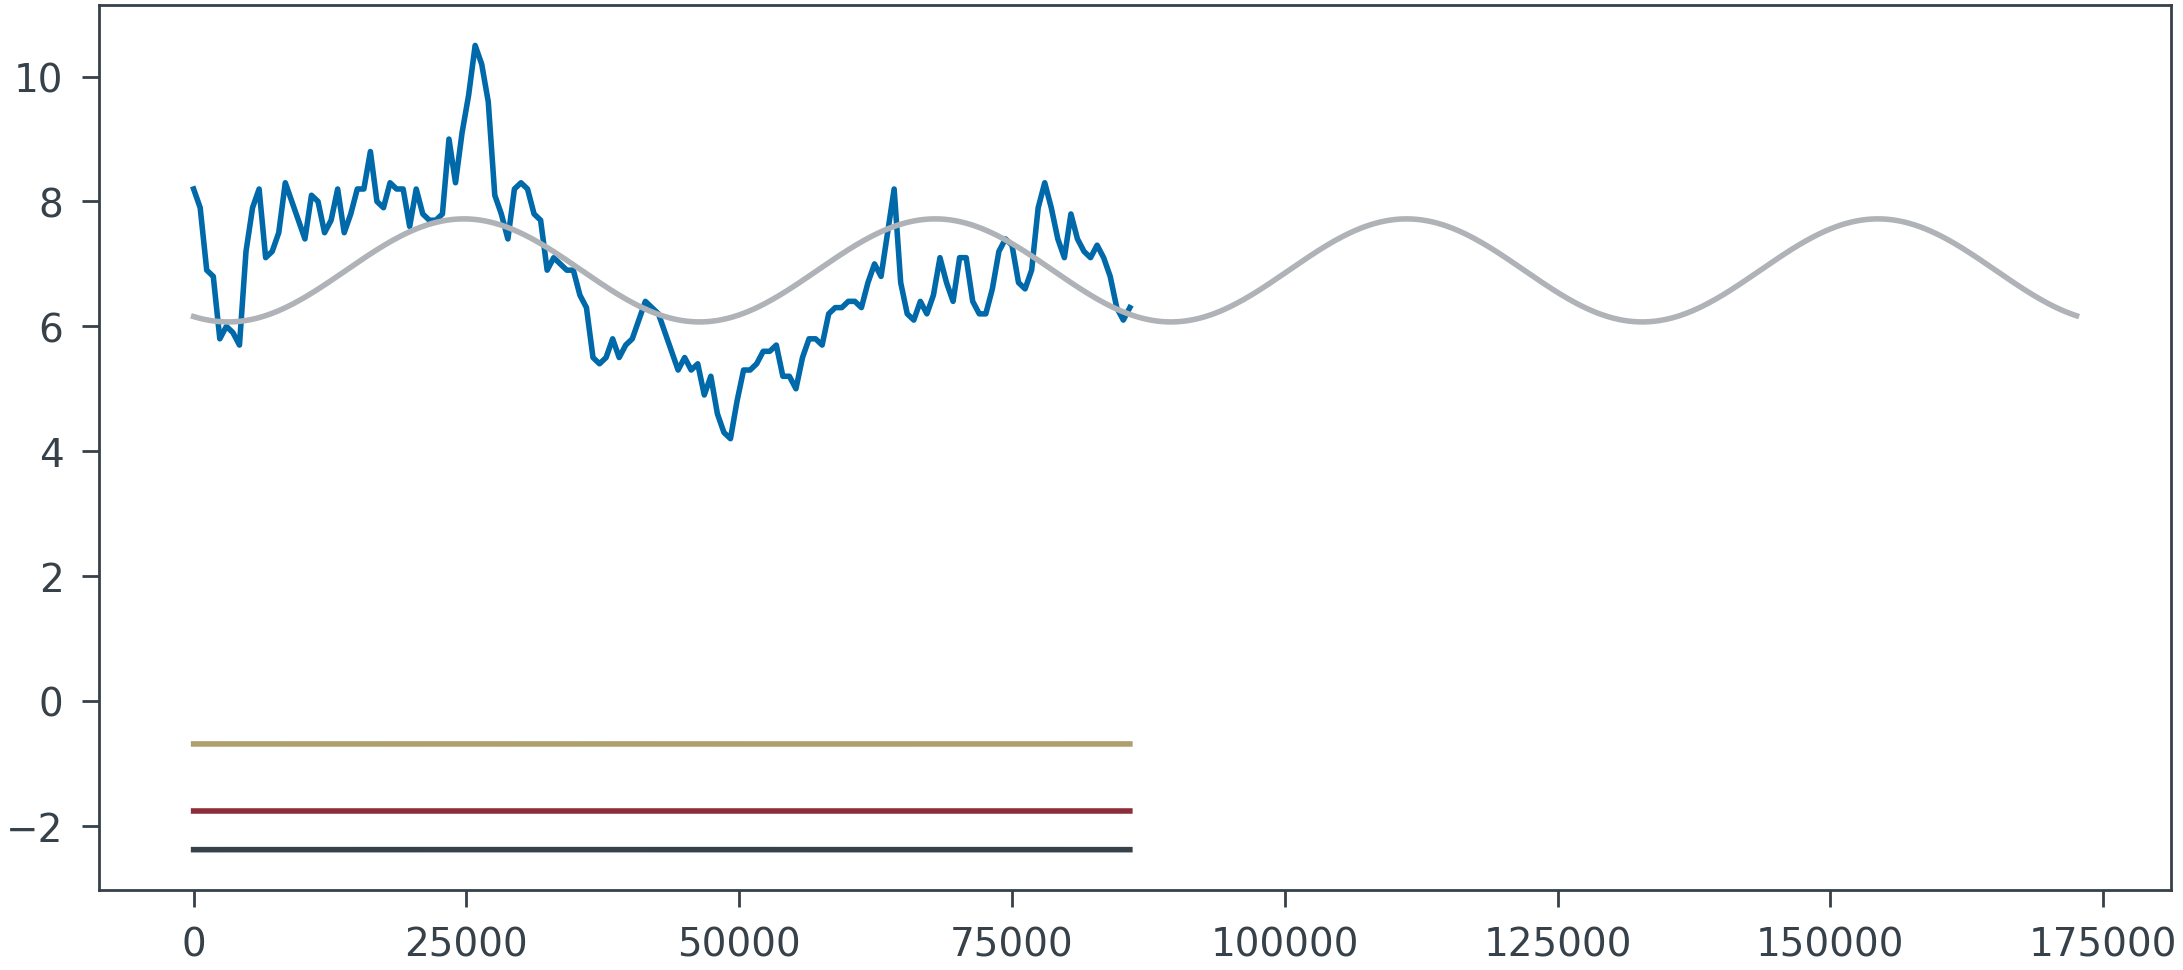

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor as GP
import sklearn.gaussian_process.kernels as GPK

# plt.plot(wind_df_2022["MESS_DATUM"], wind_df_2022["FF_10_wind"])

kernel = GPK.ExpSineSquared(length_scale=60 * 60, periodicity= 60 * 60 * 12)
gp = GP(kernel=kernel, optimizer=None)

start = pd.Timestamp("01-01-2022")
day_df = wind_df_2022[(wind_df_2022["MESS_DATUM"].dt.day == 1) & (wind_df_2022["MESS_DATUM"].dt.month == 1)].copy().dropna()
day_df["Duration"] = day_df["MESS_DATUM"] - start
X = day_df["Duration"].dt.total_seconds().values.reshape(-1, 1)
plt.plot(X, gp.sample_y(X, 3))
plt.plot(X, day_df["FF_10_wind"])

# X_out = np.vstack((X, np.linspace(85800, 85800 + 600 * 100).reshape(-1, 1)))
X_out = np.array(range(0, 24 * 60 * 60 * 2, 240)).reshape(-1, 1)
Y = day_df["FF_10_wind"]
Y_mean = Y.mean()
print(X_out.shape)
gp.fit(X, day_df["FF_10_wind"].values.reshape(-1, 1) - day_df["FF_10_wind"].mean())
pred, std = gp.predict(X_out, return_std=True)
pred += Y.mean()
plt.plot(X_out, pred)
# plt.plot(X_out, pred + std, linestyle=":", color="red", alpha=0.5)
# plt.plot(X_out, pred - std, linestyle=":", color="red", alpha=0.5)

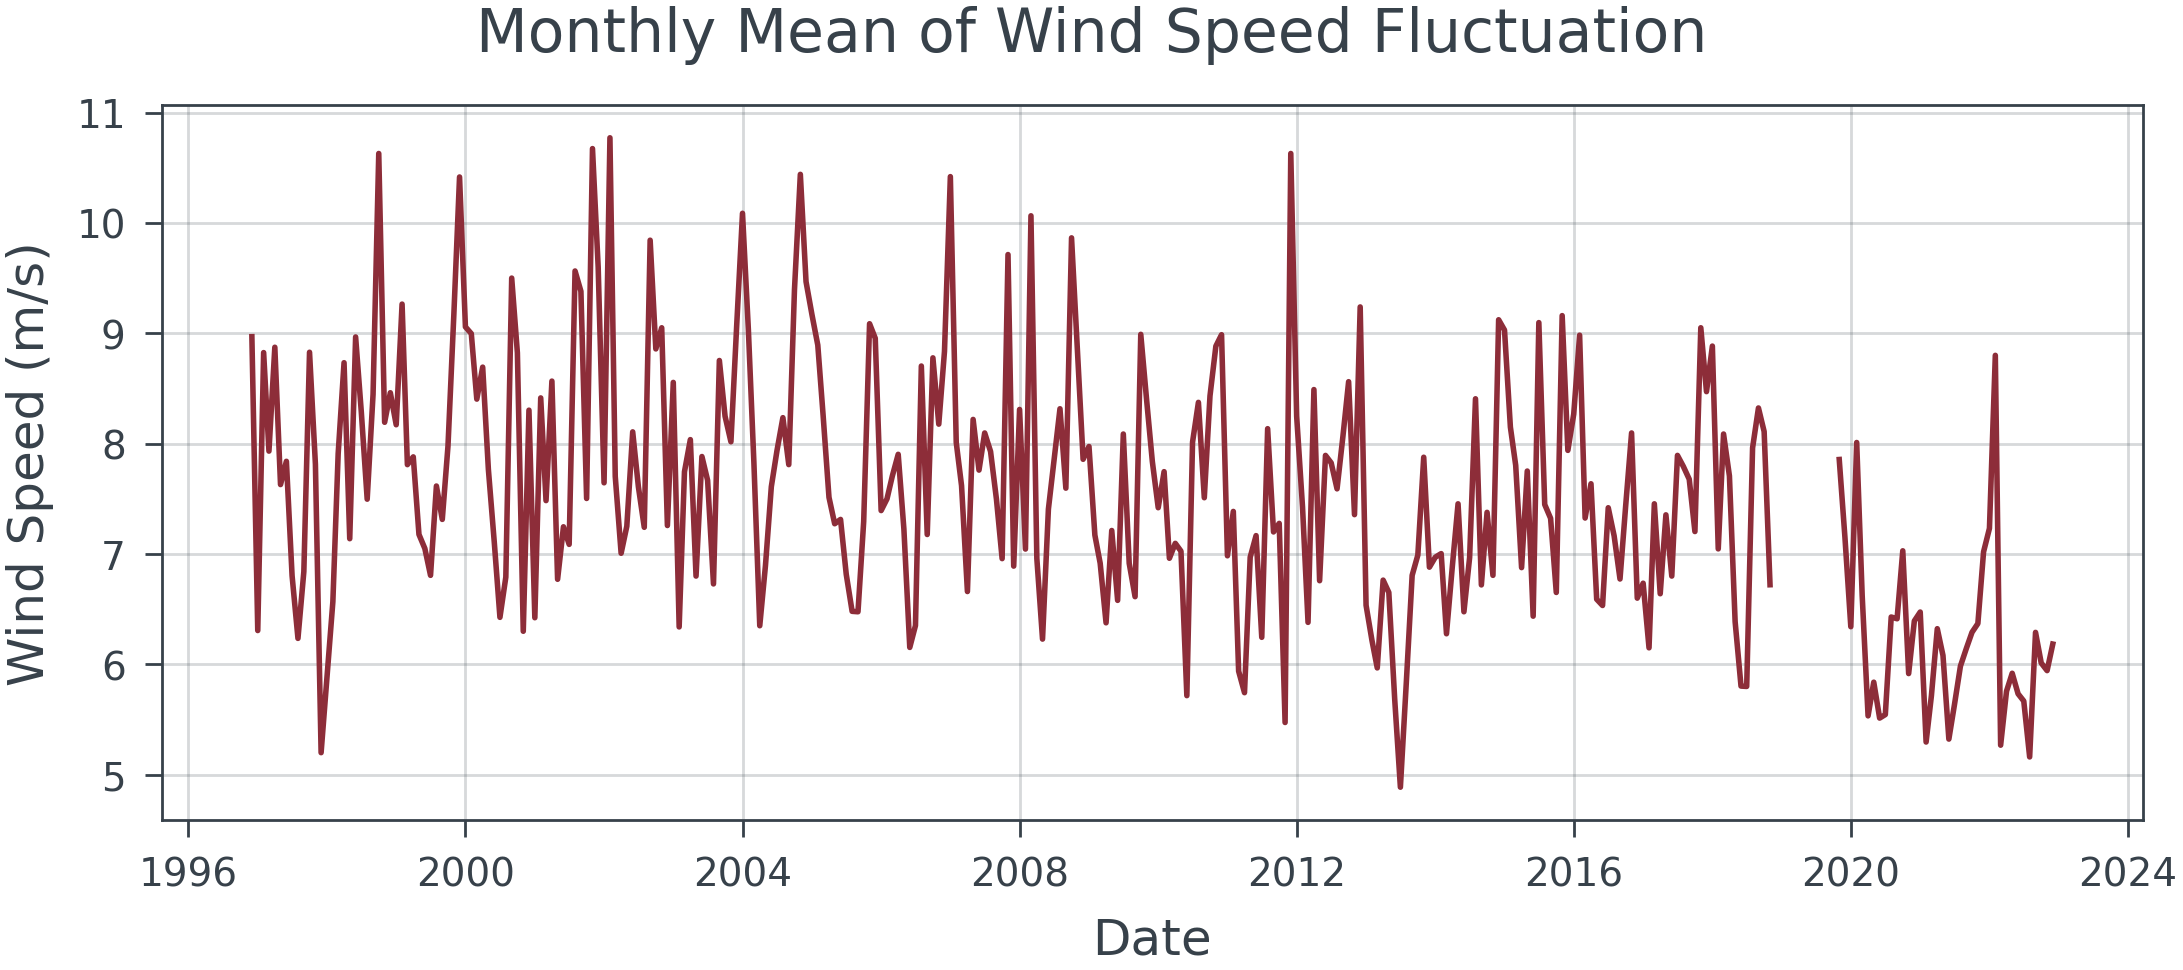

In [11]:
wind_df["year"] = wind_df["MESS_DATUM"].dt.year
wind_df["day"] = wind_df["MESS_DATUM"].dt.day
wind_df["month"] = wind_df["MESS_DATUM"].dt.month
wind_df_by_year = wind_df.groupby(["year", "month", "day"])
wind_df_agg_yr = wind_df_by_year["FF_10_wind"].aggregate(["max", "min"])
wind_df_agg_yr["diff"] = wind_df_agg_yr["max"] - wind_df_agg_yr["min"]
wind_df_agg_yr.reset_index(inplace=True)
wind_df_agg_yr["date"] = pd.to_datetime(wind_df_agg_yr[["year", "month", "day"]])

wind_df_mean_diff = wind_df_agg_yr.groupby(["year", "month"])["diff"].mean().reset_index()
wind_df_mean_diff["date"] = pd.to_datetime(wind_df_mean_diff[["year", "month"]].assign(day=1))

fig, ax = plt.subplots(1, 1)
fig.suptitle("Monthly Mean of Wind Speed Fluctuation")
ax.plot(wind_df_mean_diff["date"], wind_df_mean_diff["diff"])
ax.set_ylabel("Wind Speed (m/s)")
ax.set_xlabel("Date")
ax.grid(which="major")

Text(0.5, 0.98, 'Monthly Mean of Wind Speed Fluctuations')

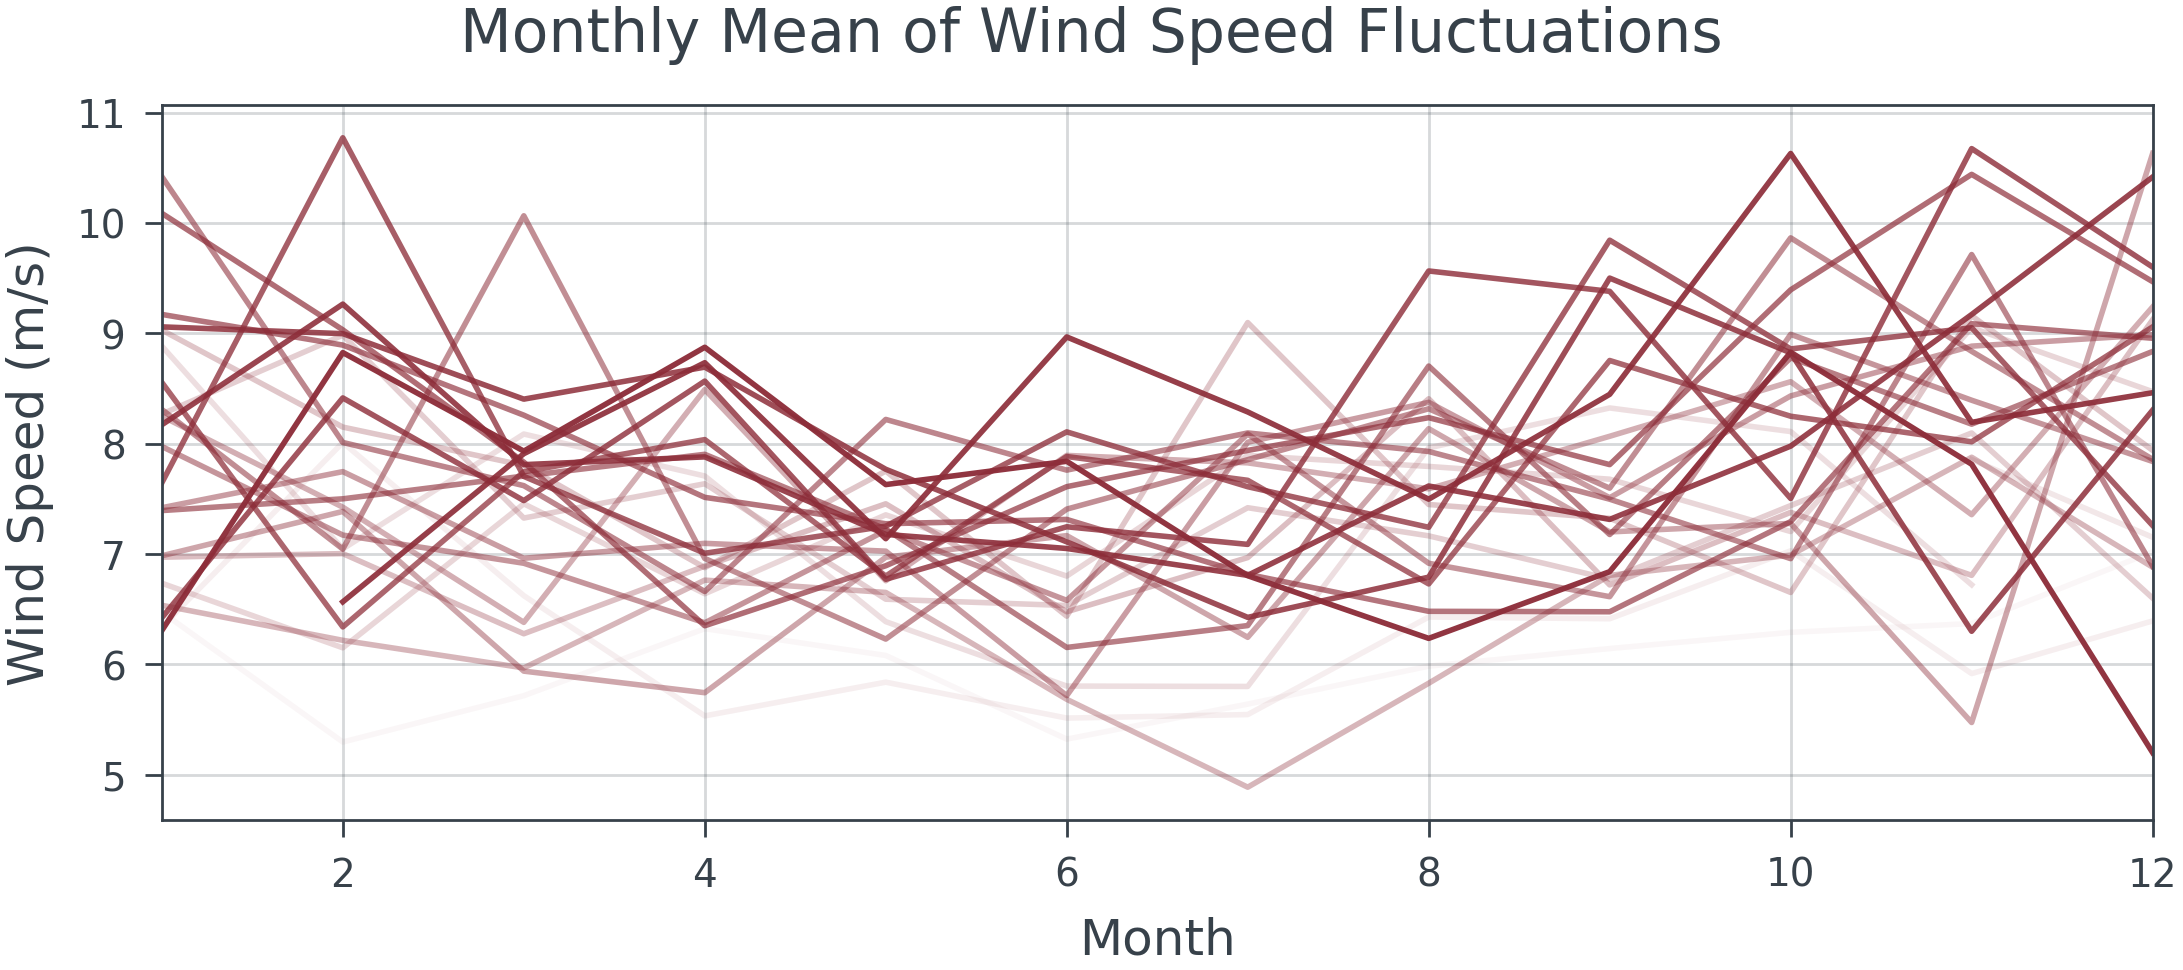

In [12]:
fig, axs = plt.subplots(1, 1)

for year, year_df in wind_df_mean_diff.groupby("year"):
    alpha = 1 - (year - 1996) / (2022 - 1996)
    axs.plot(year_df["month"], year_df["diff"], color=tp.constants.color.rgb.tue_red, alpha=alpha)
# sns.boxplot(data=wind_df_agg_yr, x=wind_df_agg_yr.index.values, y="diff")

axs.set_ylabel("Wind Speed (m/s)")
axs.set_xlabel("Month")
axs.set_xlim((1, 12))
axs.grid(which="major")
fig.suptitle("Monthly Mean of Wind Speed Fluctuations")
# wind_df_mean_diff.groupby("year")["diff"].plot(kind="kde", ax=axs[1])

Text(0.5, 0, 'Wind Speeds (m/s)')

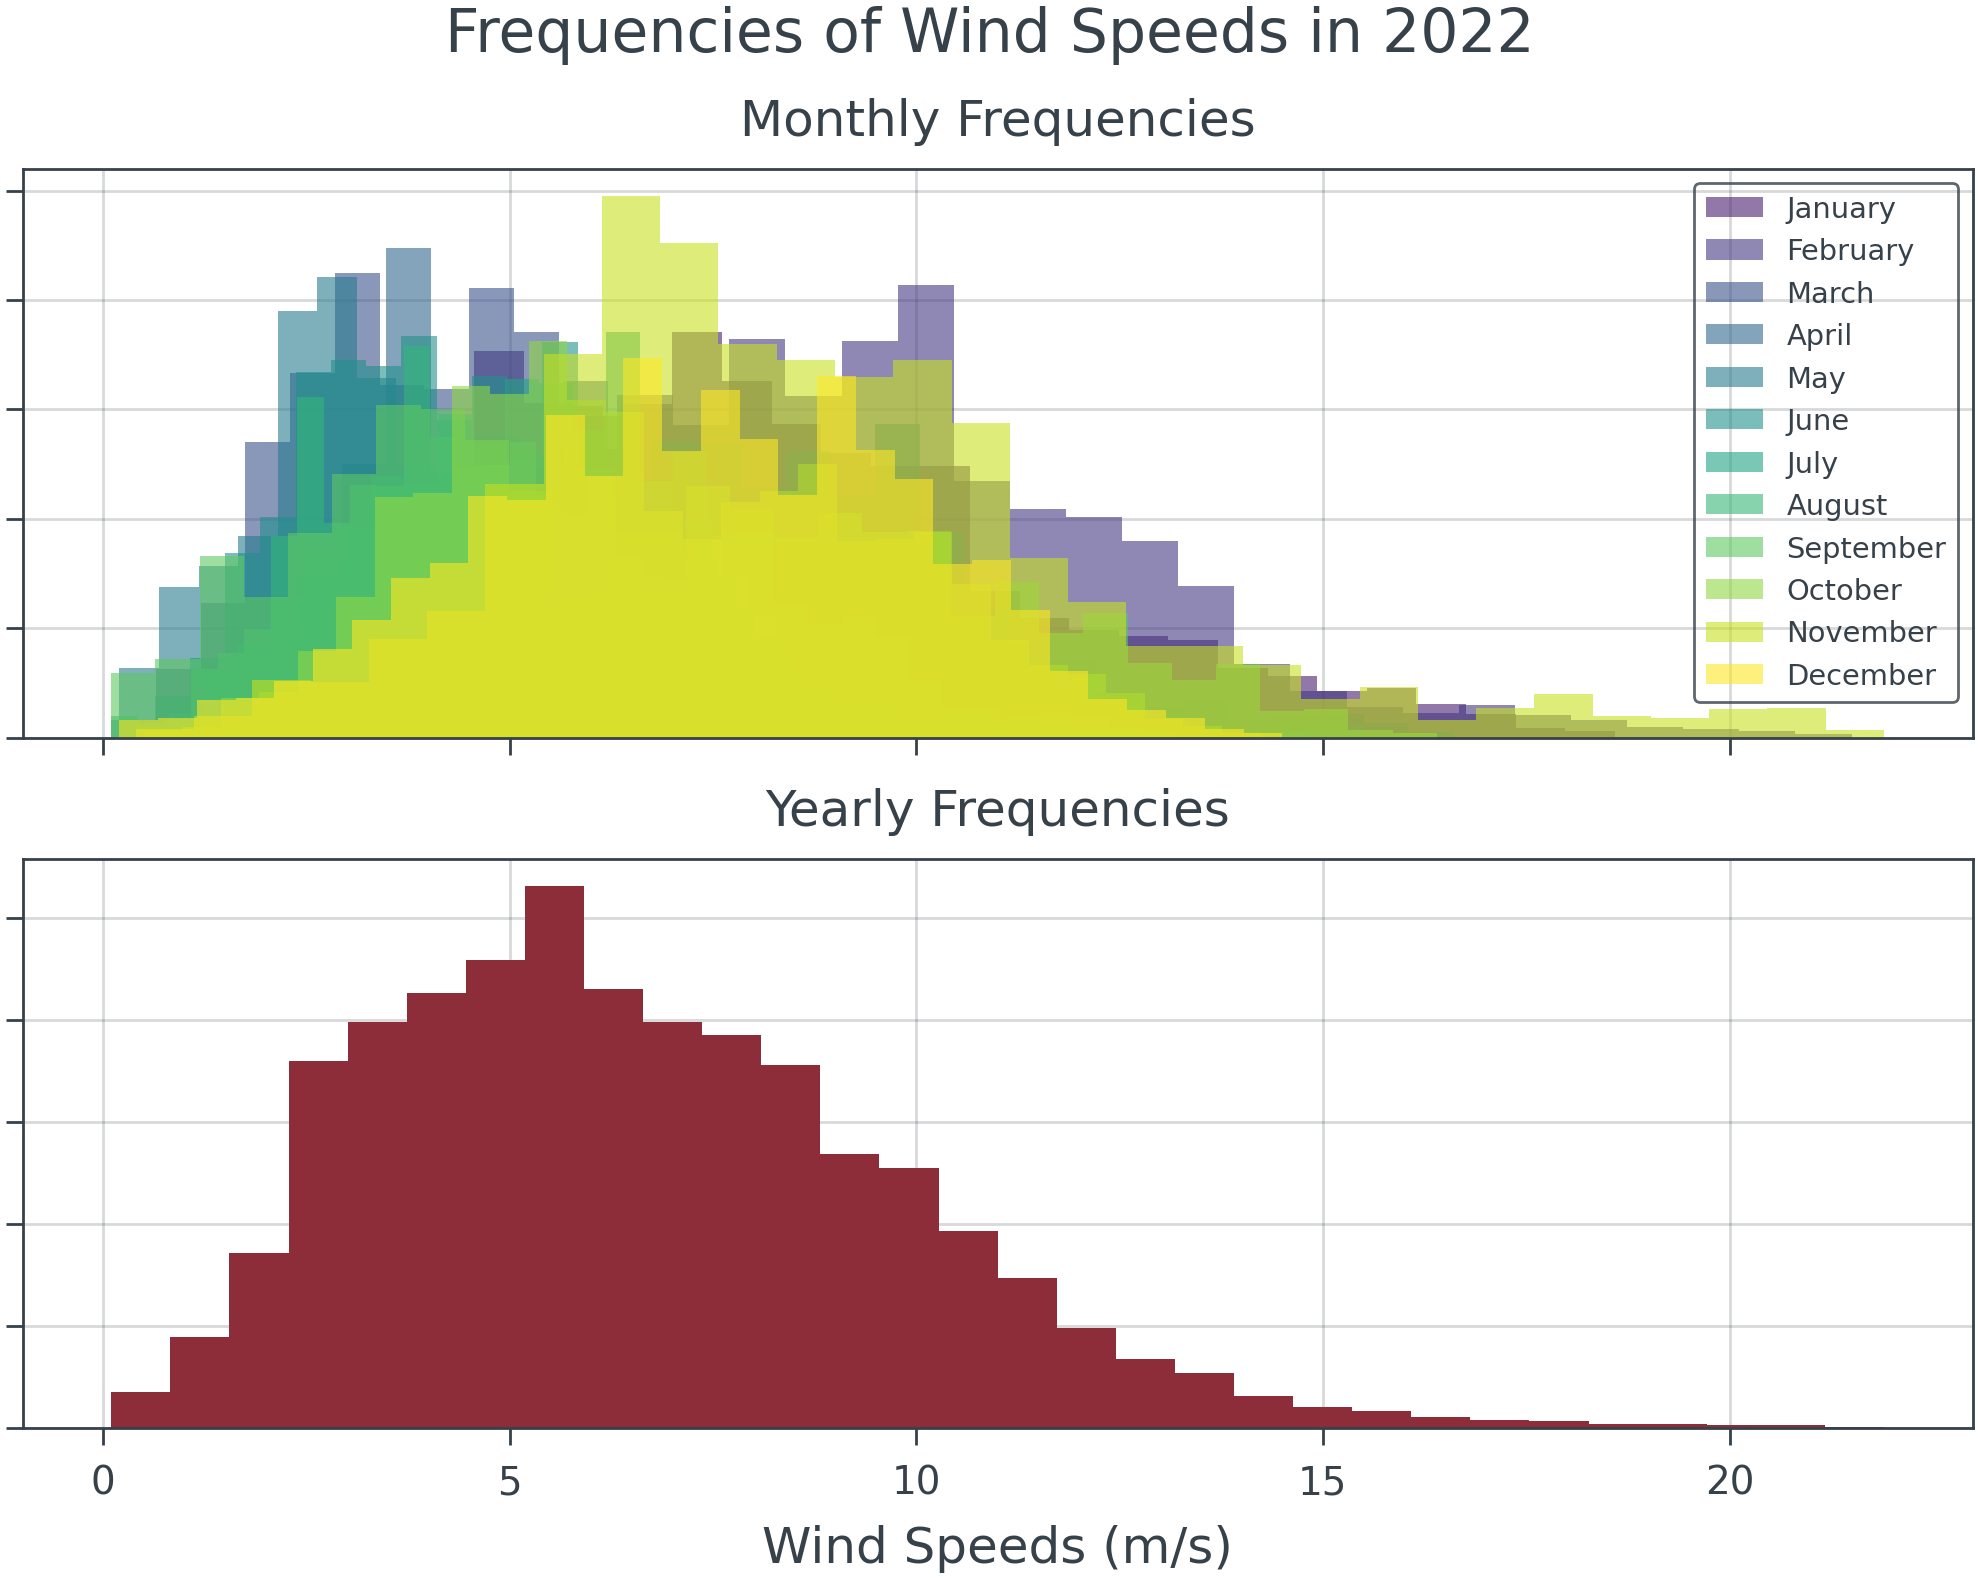

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 4))
# Create a list of colors for the colormap (here, we use a smooth transition from blue to red to blue)
colors = plt.cm.viridis(np.linspace(0, 1, 13))

fig.suptitle("Frequencies of Wind Speeds in 2022")
wind_df_2022["month"] = wind_df_2022["MESS_DATUM"].dt.month
for year, year_df in wind_df_2022.groupby("month"):
    year_df.hist(column="FF_10_wind", bins=30, ax=ax1, alpha=0.6, label=dt.datetime(2022, year, 1).strftime("%B"), color=colors[year])
# wind_df_2022[wind_df_2022["MESS_DATUM"].dt.month == 6].hist(column="FF_10_wind", bins=20, ax=ax)
ax1.set_title("")
ax1.set_yticklabels([])
# ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_title("Monthly Frequencies")
ax1.legend(loc="upper right", fontsize="xx-small")

wind_df_2022.hist(column="FF_10_wind", bins=30, ax=ax2)
ax2.set_title("Yearly Frequencies")
ax2.set_yticklabels([])
ax2.set_xlabel("Wind Speeds (m/s)")

Text(0.5, 0.98, 'Yearly Frequencies & Weibull Estimation of Wind Speeds (2022)')

findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed


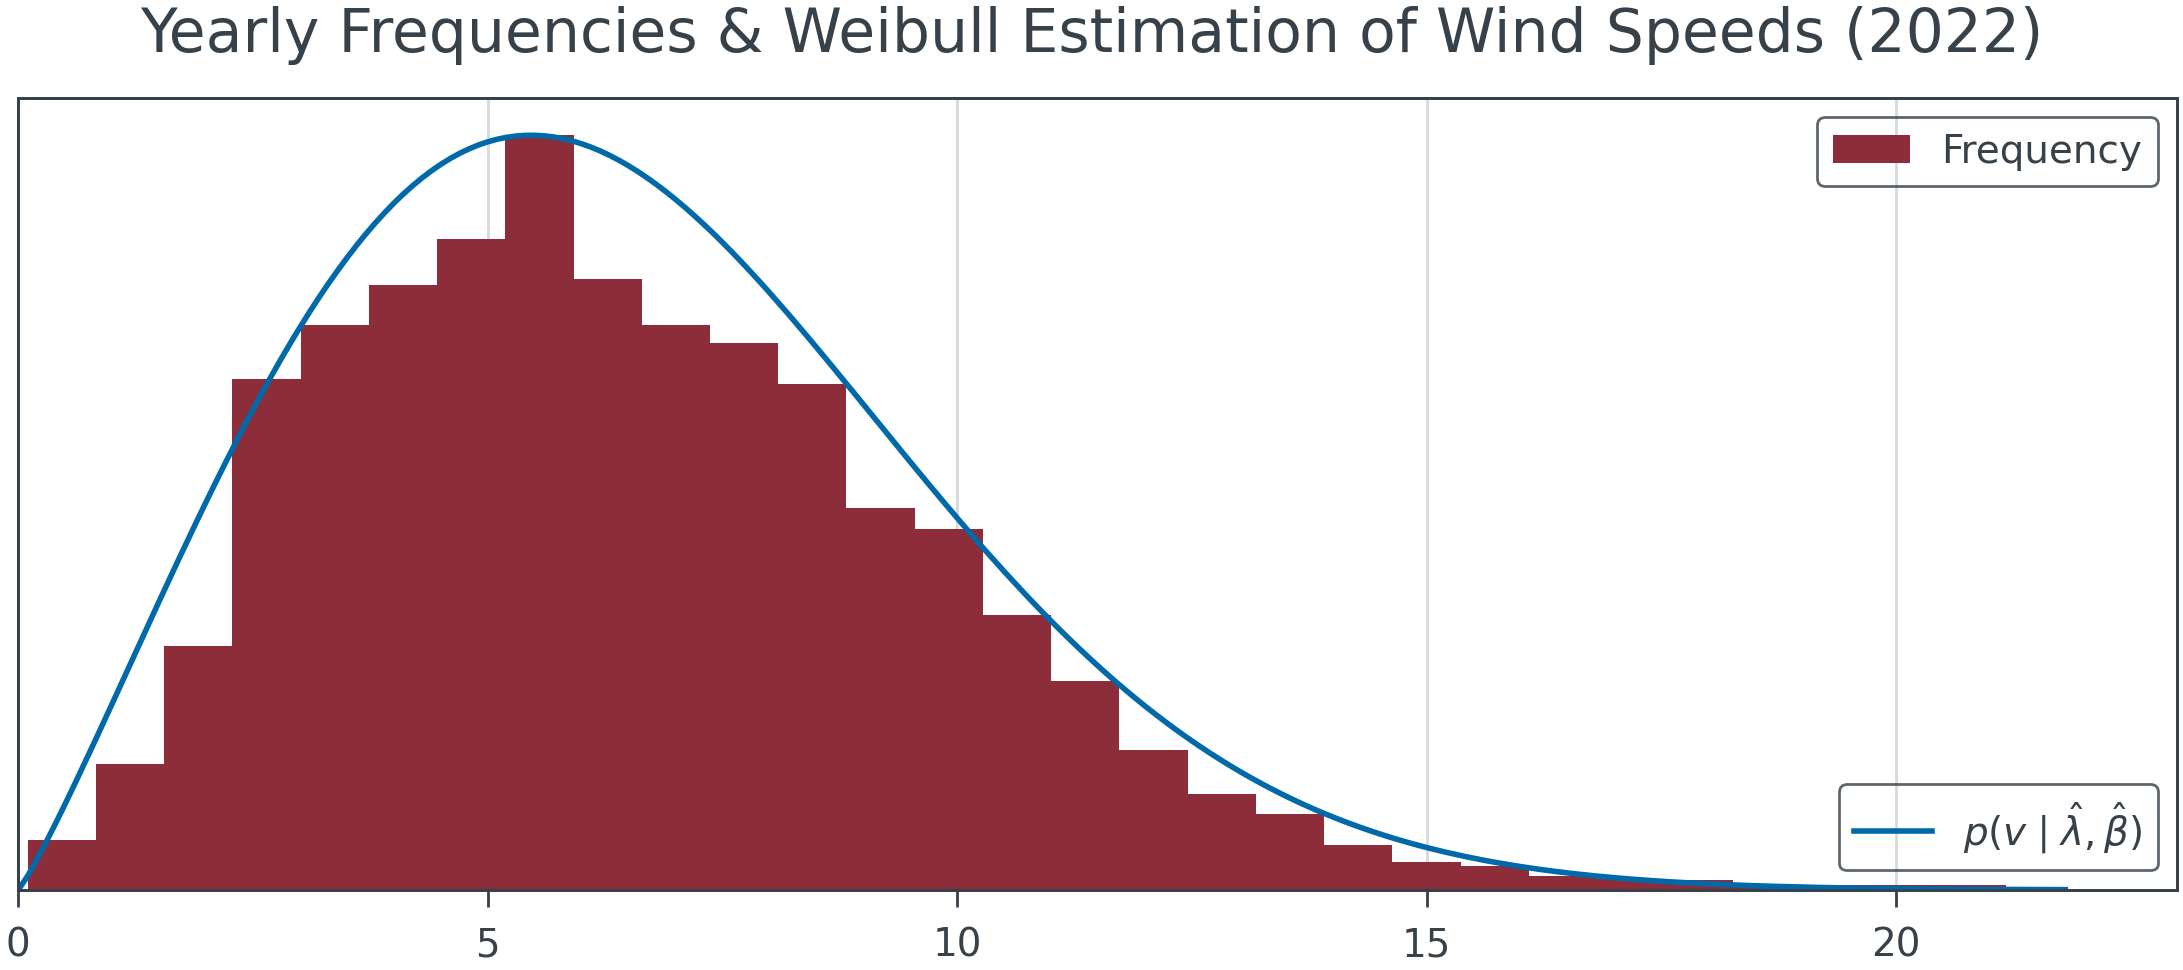

In [46]:
fig, ax = plt.subplots(1, 1)

def weibull_pdf(x, l, b):
    return b / l * (x / l) ** (b - 1) * np.exp(- (x / l) ** b)

def opt_lambda(X, beta):
    N = X.shape[0]
    return (1 / N * np.sum(X ** beta)) ** (1/beta)

def opt_beta(X):
    N = X.shape[0]
    l_fn = lambda beta: - 1 / N * np.sum(np.log(X)) - 1 / beta + np.sum(X ** beta * np.log(X)) / np.sum(X ** beta)
    return opt.root(l_fn, 2.0)

Y = wind_df_2022["FF_10_wind"].fillna(0.1).to_numpy()
b = opt_beta(Y).x
l = opt_lambda(Y, b)
X = np.arange(0, np.max(Y), 0.1)

ax1 = ax.twinx()
ax1.plot(X, weibull_pdf(X, l, b), color=tp.constants.color.rgb.tue_blue, label=r"$p(v \mid \hat{\lambda}, \hat{\beta})$")
ax1.set_ylim(0)
ax1.set_yticklabels([])
ax1.set_yticks([])
ax1.legend(loc="lower right")


wind_df_2022.hist(column="FF_10_wind", bins=30, ax=ax, color=tp.constants.color.rgb.tue_red, label="Frequency")
ax.set_title("")
ax.set_xlim(0)
ax.set_yticklabels([])
ax.set_yticks([])
ax.legend(loc="upper right")
fig.suptitle("Yearly Frequencies & Weibull Estimation of Wind Speeds (2022)")

Text(0, 0.5, '$p(v \\mid \\hat{\\lambda}, \\hat{\\beta})$')

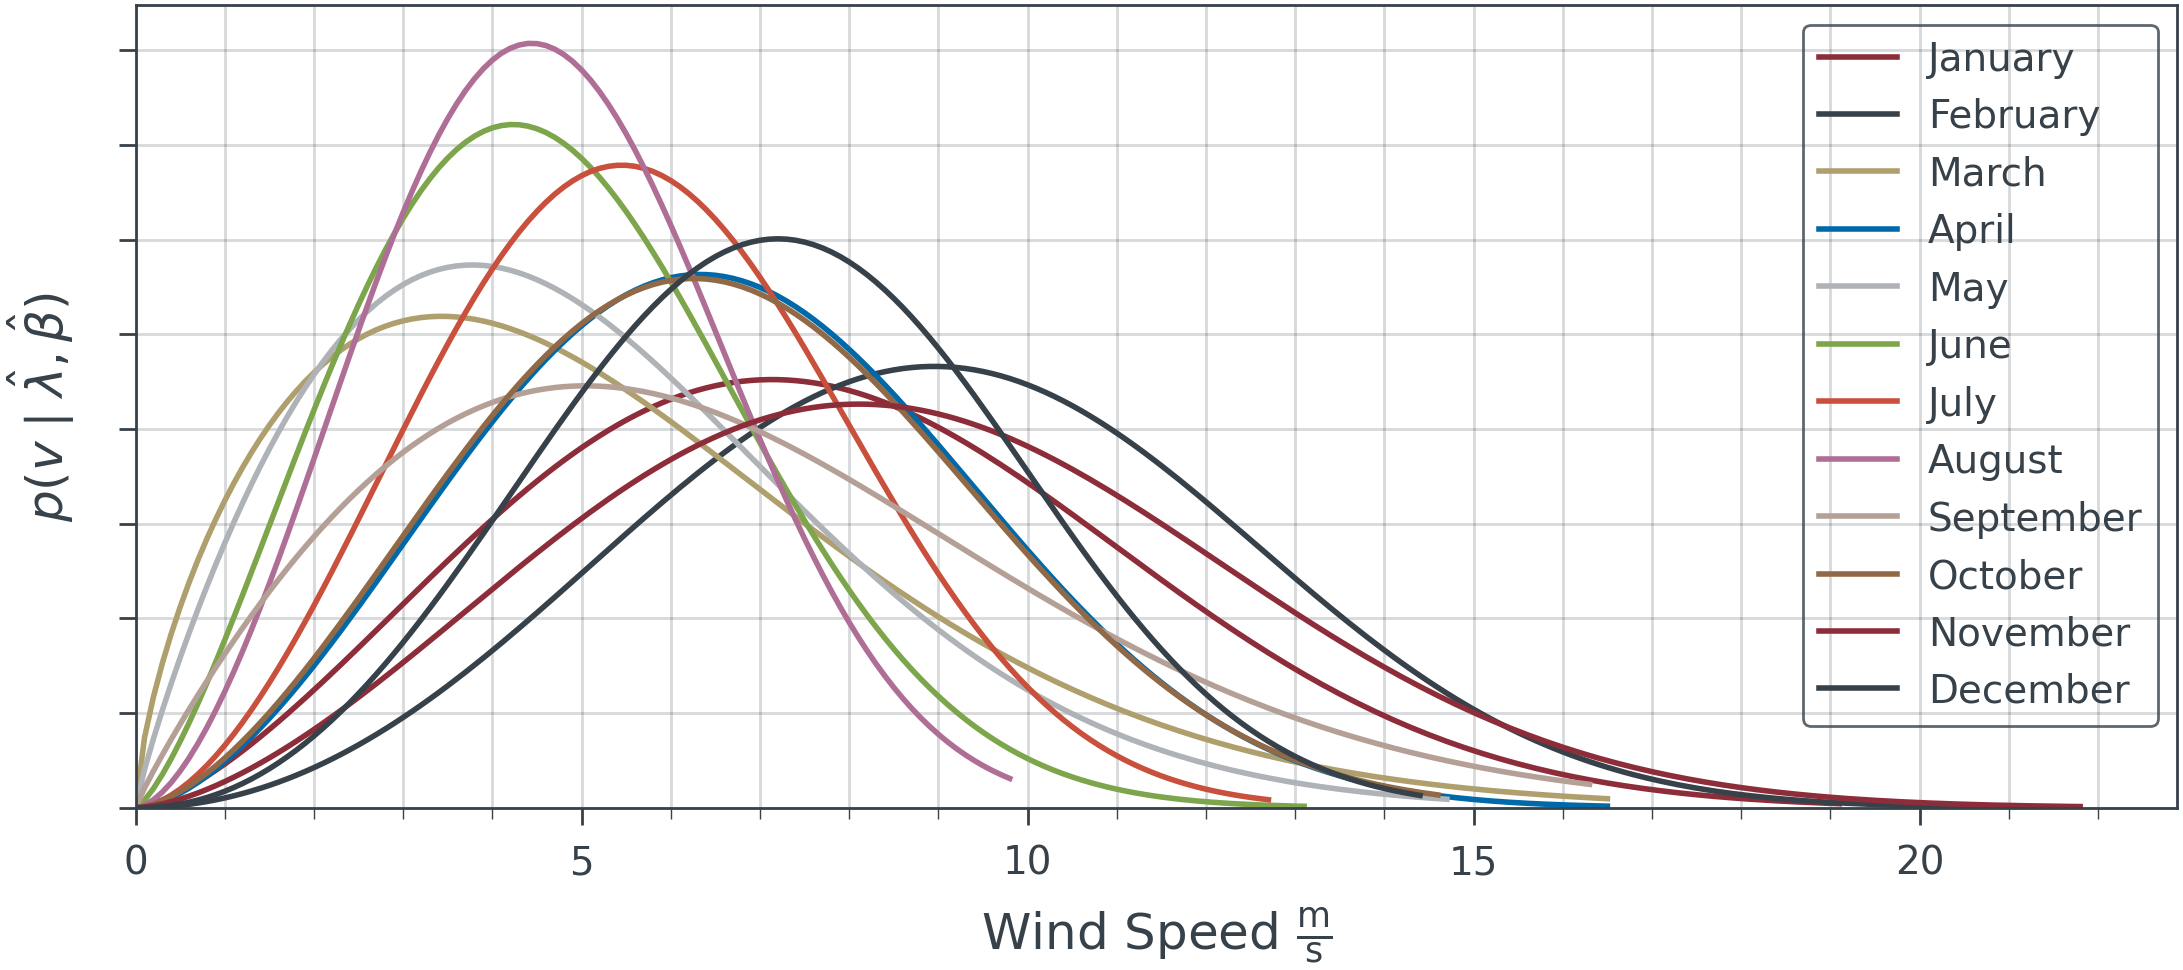

In [65]:
fig, ax = plt.subplots(1, 1)

for year, year_df in wind_df_2022.groupby("month"):
    Y = year_df["FF_10_wind"].replace(0, 1e-3).fillna(0.1).to_numpy()
    X = np.arange(0, np.max(Y), 0.1)
    b = opt_beta(Y).x
    l = opt_lambda(Y, b)
    ax.plot(X, weibull_pdf(X, l, b), label=dt.datetime(2022, year, 1).strftime("%B"))
    
ax.grid(which="both")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.set_yticklabels([])
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend()
ax.set_xlabel(r"Wind Speed $\frac{\text{m}}{\text{s}}$")
ax.set_ylabel(r"$p(v \mid \hat{\lambda}, \hat{\beta})$")

Text(0, 0.5, '$p(v \\mid \\hat{\\lambda}, \\hat{\\beta})$')

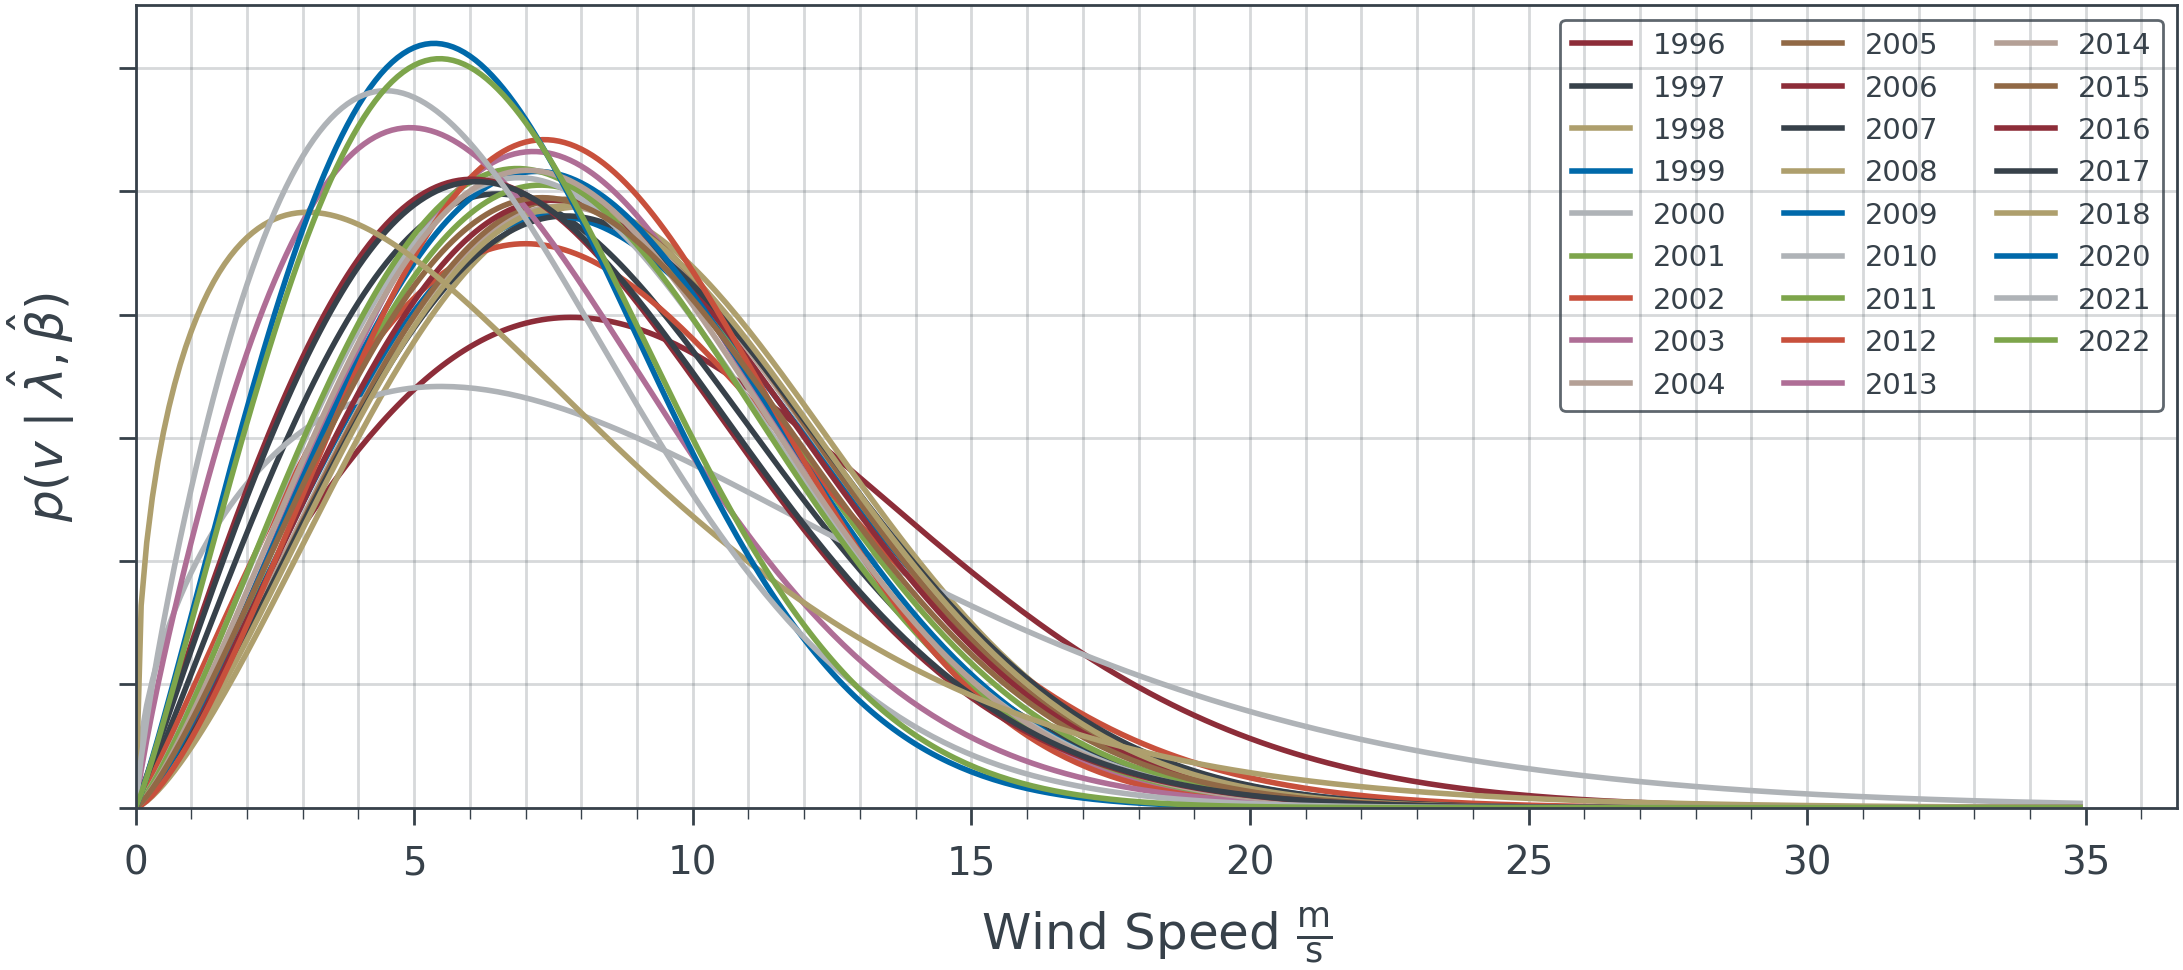

In [82]:
ig, ax = plt.subplots(1, 1)

for year, year_df in wind_df.groupby("year"):
    if year == 2019:
        continue
    Y = year_df["FF_10_wind"].replace(0, 1e-1).fillna(0.1).to_numpy()
    X = np.arange(0, 35, 0.1)
    b = opt_beta(Y).x
    l = opt_lambda(Y, b)
    ax.plot(X, weibull_pdf(X, l, b), label=year)

ax.grid(which="both")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.set_yticklabels([])
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(ncols=(2022 - 1996) / 8, fontsize="xx-small")
ax.set_xlabel(r"Wind Speed $\frac{\text{m}}{\text{s}}$")
ax.set_ylabel(r"$p(v \mid \hat{\lambda}, \hat{\beta})$")